# NLP from Scratch with PyTorch, fastai, and HuggingFace
> A technical NLP tutorial using a variety of libraries to show the different levels/layers of common NLP pipelines

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, nlp, pytorch, fastai, huggingface]
- image: images/pfh.png

# 0. Introduction

Welcome! In this blog post/notebook, we'll be looking at NLP with 3 different methods:

- From Scratch/Ground-Up, with [PyTorch](https://pytorch.org/)
- FastAI Language Model ([AWD-LSTM](https://docs.fast.ai/text.models.awdlstm.html#AWD_LSTM))
- HuggingFace Transformers ([DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html))

All 3 methods will utilize fastai to assist with keeping things organized and help with training the models, given the libary's ease of use through it's lovely [Layered-API](https://www.fast.ai/2020/02/13/fastai-A-Layered-API-for-Deep-Learning/)!

In [1]:
#hide

# Uncomment the below cells if you need to install everything!

# !pip install torch==1.9.0
# !pip install torchtext==0.10
# !pip install transformers==4.7
# !pip install fastai==2.4

# 1. Looking at the Data [Pandas]

For this notebook, we'll be looking at the Amazon Reviews Polarity dataset! The task is to predict whether a review is of positive or negative sentiment. The original Amazon Reviews dataset contains review scores ranging from 1-5. This polarity dataset combines review scores 1-2 into the negative class, 4-5 into the positive class, and ignores/drops review scores of 3!

In [2]:
from fastai.text.all import *
import pandas as pd

In [3]:
path = untar_data(URLs.AMAZON_REVIEWS_POLARITY)
path

Path('/home/saini5/.fastai/data/amazon_review_polarity_csv')

In [4]:
path.ls()

(#3) [Path('/home/saini5/.fastai/data/amazon_review_polarity_csv/train.csv'),Path('/home/saini5/.fastai/data/amazon_review_polarity_csv/readme.txt'),Path('/home/saini5/.fastai/data/amazon_review_polarity_csv/test.csv')]

Let's go ahead and take a look at our two df's: `train_df` and `valid_df`

> Note: We're going to use 40k instead of 3.6m samples for training, and 2k instead of 400k samples for validation

In [5]:
train_df = pd.read_csv(path/'train.csv', names=['label', 'title', 'text'], nrows=40000)
valid_df = pd.read_csv(path/'test.csv', names=['label', 'title', 'text'], nrows=2000)
train_df.head()

,label,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
1,2,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
2,2,Amazing!,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if you've played the game) and the hope in ""A Distant Promise"" and ""Girl who Stole the Star"" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like ""Chrono Cross ~ Time's Scar~"", ""Time of the Dreamwatch"", and ""Chronomantique"" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xenogears s..."
3,2,Excellent Soundtrack,"I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Uns..."
4,2,"Remember, Pull Your Jaw Off The Floor After Hearing it","If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper."


> Note: label 1 is negative sentiment and label 2 is positive sentiment

In [6]:
len(train_df), len(valid_df)

(40000, 2000)

# 2. Tokenization and Numericalization [PyTorch]

We now want to first tokenize our inputs, then numericalize them using a vocab. Quick recap of these terms:

- *Tokenization* = The process of converting an input string into "pieces"
  - These pieces can be **whole words**, **sub words**, or even **characters**
- *Numericalization* = The process of converting a token into a numeric representation
  - (e.g. token -> number)
  - This is done through the use (and creation of) a **vocab**

There are many fancy tokenizers out there, but since we're first doing things from scratch we'll go ahead and use a simple `basic_english` tokenizer from `torchtext` and split on spaces

> Tip: More popular tokenizer pipelines can be found in libraries such as [SpaCy](https://spacy.io/api/tokenizer), [HuggingFace](https://huggingface.co/transformers/main_classes/tokenizer.html), and [fastai](https://docs.fast.ai/text.core.html#Tokenizing)!

In [7]:
sample_text = train_df['text'][0]
sample_text

'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [8]:
import torch
import torchtext
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")

> Tip: Reminder that fastai's `L` is basically `list` from Python, but has some convienent properties such as displaying the number of elements, and  additionally doesn't spam your screen with output if the list is too long!

In [9]:
tokens = L(tokenizer(sample_text))
tokens

(#81) ['this','sound','track','was','beautiful','!','it','paints','the','senery'...]

> Note: Since we're using a full word tokenizer, many of these words will be quite infrequent, such as typos or words with repetiting characters like `Dudeeeee`. Other tokenizers can use rules to better handle splitting of big words through subword tokenization, and can also handle numbers like prices as well. This would help with optimizing the **vocab's embedding table** as well as reducing the number of `<unk>` tokens.

Next we'll need to check how many tokens there are in our dataset, and keep the frequent ones as part of our vocab.

In [10]:
from collections import Counter

token_counter = Counter()

for sample_text in train_df['text']:
    tokens = tokenizer(sample_text)
    token_counter.update(tokens)

token_counter.most_common(n=25)

[('.', 213962),
 ('the', 158787),
 (',', 116525),
 ('i', 91270),
 ('and', 86059),
 ('a', 77977),
 ('to', 74984),
 ('it', 69999),
 ('of', 65144),
 ("'", 60523),
 ('this', 59382),
 ('is', 56445),
 ('in', 37890),
 ('that', 33891),
 ('for', 30532),
 ('was', 29163),
 ('you', 26740),
 ('!', 25238),
 ('book', 24698),
 ('s', 23897),
 ('but', 22602),
 ('with', 21998),
 ('not', 21988),
 ('on', 20759),
 ('t', 20097)]

> Note: The top 25 most common tokens are listed above! Let's see what the least frequent tokens look like:

In [11]:
token_counter.most_common()[-25:]

[('knorflefob', 1),
 ('<<dan', 1),
 ('bg', 1),
 ('apquire$', 1),
 ('gtube', 1),
 ('chafe', 1),
 ('lubricates', 1),
 ('lubricate', 1),
 ('flights/vacation', 1),
 ('lambdin', 1),
 ('trafalgar', 1),
 ('bloodedly', 1),
 ('undifferentiated', 1),
 ('code--no', 1),
 ('exciting--because', 1),
 ('nicaea', 1),
 ('full-grown', 1),
 ('yon', 1),
 ('medium-to-large', 1),
 ('ms-supplied', 1),
 ('well@@', 1),
 ('in-touch', 1),
 ('*ms', 1),
 ('specialist*', 1),
 ('schapiro', 1)]

In [12]:
len(token_counter)

75889

In [13]:
token_counter['well@@'], token_counter['well']

(1, 5418)

> Important: There were **78,157** unique tokens! It's interesting seeing that some of them are typos, or just have additional characters attached to the word, such as `well@@` instead of `well`

Now that we have our token frequency counter, we can go ahead and make our vocab!

In [14]:
# Sort our counter so our vocab will have the most common tokens listed first
sorted_counter = dict(token_counter.most_common())

# Create vocab containing tokens with a minimum frequency of 20
my_vocab = torchtext.vocab.vocab(sorted_counter, min_freq=20)

# Add the unknown token, and use this by default for unknown words
unk_token = '<unk>'
my_vocab.insert_token(unk_token, 0)
my_vocab.set_default_index(0)

# Add the pad token
pad_token = '<pad>'
my_vocab.insert_token(pad_token, 1)

# Show vocab size, and examples of tokens
len(my_vocab.get_itos()), my_vocab.get_itos()[:25]

(7591,
 ['<unk>',
  '<pad>',
  '.',
  'the',
  ',',
  'i',
  'and',
  'a',
  'to',
  'it',
  'of',
  "'",
  'this',
  'is',
  'in',
  'that',
  'for',
  'was',
  'you',
  '!',
  'book',
  's',
  'but',
  'with',
  'not'])

> Important: We'll be using `<unk>` as our default token for tokens that are out of our vocab!

> Important: Notice how we passed in a `min_freq` argument. This ensures that the vocab only includes high frequency tokens. We wouldn't want to include tokens that only occur once/rarely. This brought our vocab count down from **75,889** to **7,591**! A **~90% reduction**!

Rather than starting from scratch, we can preload GloVe embeddings into our vocabulary!

In [15]:
# Pretrained word vectors/embeddings
glove = torchtext.vocab.GloVe(name = '6B', dim = 100)
glove.vectors.shape

torch.Size([400000, 100])

Since we're using GloVe vectors for *transfer learning* (by preloading our embedding), let's take a look at how many tokens can be successfully transferred from GloVe into our own vocab. Each token will have an embedding (vector) of size 100. This results in an embedding of size **7591x100**

In [16]:
# Preloading our vocab with embeddings if our vocab shares similar tokens to GloVe
my_vocab.vectors = glove.get_vecs_by_tokens(my_vocab.get_itos())
my_vocab.vectors.shape

torch.Size([7591, 100])

By default, tokens that aren't able to transfer from GloVe into our own dataset get initialized with a vector of 0's. We can use this to count how many tokens were successfully preloaded!

In [17]:
tot_transferred = 0
for v in my_vocab.vectors:
    if not v.equal(torch.zeros(100)):
        tot_transferred += 1
        
tot_transferred, len(my_vocab)

(7517, 7591)

> Important: Not bad, 7517 out of our 7591 tokens were successfully transferred!

In [18]:
my_vocab.get_itos()[3], my_vocab.vectors[3]

('the',
 tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
         -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
          0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
          0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
          0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
         -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
         -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
          0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
          1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
         -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
          0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
          0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.5106,
         -0.5203, -0

In [19]:
my_vocab.get_itos()[6555], my_vocab.vectors[6555]

('eargels',
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]))

> Note: Note that the vector for index 3 corresponds to the word/token `the` and it has non-zero values in the vector since we were able to preload it from GloVe! Index 6559 corresponds to the word `eargels` and it's all zeros, which means that it wasn't part of Glove's vocab and therefore couldn't transfer it's embedding to our vocab!

> Note: There were 400k tokens/words in GloVe, and `stardust` wasn't one of them :O

> Warning: Initializing the embeddings to 0 isn't the best idea. If we use these embeddings for transfer learning to our embedding layer, then **all** new tokens not found in GloVe will have an indentical vector representation of all 0s. I found the model to be harder to train because of this, and I concluded that it's due to these 0s being multiplied in our model's forward pass which creates more 0s, and possibly cause some gradients to be 0, making it much more difficult to learn these new embeddings.

> Tip: Rather than initializing new token embeddings to 0's, let's use `torch.randn` to create some diversity between the different token embeddings that weren't preloaded with GloVe!

In [20]:
for i in range(my_vocab.vectors.shape[0]):
    if my_vocab.vectors[i].equal(torch.zeros(100)):
        my_vocab.vectors[i] = torch.randn(100)

Now let's use our vocab to *numericalize* our tokens!

In [21]:
sample_text = train_df['text'][0]
sample_text

'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [22]:
tokens = L(tokenizer(sample_text))
tokens

(#81) ['this','sound','track','was','beautiful','!','it','paints','the','senery'...]

We can use our vocab to convert each token to it's numeric representation one-by-one using a list comprehension!

In [23]:
numericalized_tokens = [my_vocab[token] for token in tokens]
numericalized_tokens = torch.tensor(numericalized_tokens)
numericalized_tokens

tensor([  12,  222,  505,   17,  405,   19,    9, 5931,    3,    0,   14,   74,
         424,   34,   85,    5,   49, 1490,    9,   78,    8,  120,   70,  704,
           0,    2,  255,  133,   19,    5,   27,  545,    3,  255,    0, 2380,
          22,   55,   10,   33,   10,    3,  801,    5,   27,  136,  545,    9,
          53,    3,  107,  133,   19,    9,    0,  274,   45, 3843,    0,    6,
         433,    7,    0, 1368,   23,    0, 3306,    6, 3844,    0,    2,    9,
          49, 4234,  183,   70, 2260,    8,  344,   19,    0])

In [24]:
' '.join([my_vocab.get_itos()[num] for num in numericalized_tokens])

'this sound track was beautiful ! it paints the <unk> in your mind so well i would recomend it even to people who hate <unk> . game music ! i have played the game <unk> cross but out of all of the games i have ever played it has the best music ! it <unk> away from crude <unk> and takes a <unk> step with <unk> guitars and soulful <unk> . it would impress anyone who cares to listen ! <unk>'

In [25]:
numericalized_tokens.shape

torch.Size([81])

> Note: Notice how uncommon words have value `0` in their numericalized form! This corresponds to the `<unk>` token.

This example has 81 tokens, but other examples may have more or less. It'll be a good idea to cap the number of tokens + pad the amount of tokens to a desired number of tokens. This will be needed in order to batch our samples together, as they can't vary in size!

In [26]:
max_tokens = 128

In [27]:
numericalized_tokens = [my_vocab[token] for token in tokens]

if len(numericalized_tokens) < max_tokens:
    numericalized_tokens += [1] * (max_tokens-len(numericalized_tokens))
else:
    numericalized_tokens = numericalized_tokens[:max_tokens]

numericalized_tokens = torch.tensor(numericalized_tokens)
numericalized_tokens

tensor([  12,  222,  505,   17,  405,   19,    9, 5931,    3,    0,   14,   74,
         424,   34,   85,    5,   49, 1490,    9,   78,    8,  120,   70,  704,
           0,    2,  255,  133,   19,    5,   27,  545,    3,  255,    0, 2380,
          22,   55,   10,   33,   10,    3,  801,    5,   27,  136,  545,    9,
          53,    3,  107,  133,   19,    9,    0,  274,   45, 3843,    0,    6,
         433,    7,    0, 1368,   23,    0, 3306,    6, 3844,    0,    2,    9,
          49, 4234,  183,   70, 2260,    8,  344,   19,    0,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])

> Important: Remember that the pad token is represented by a 1 in it's numericalized form!

# 3. Dataset & DataLoaders [PyTorch & fastai]

Now that we have everything we need to tokenize and numericalize our input, let's go ahead and make a simple Dataset class

In [28]:
#collapse
from torch import nn

class Simple_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab, max_tokens):
        self.df = df
        self.vocab = vocab
        self.max_length = max_tokens
        self.tokenizer = get_tokenizer("basic_english")
        
        # label 1 is negative sentiment and label 2 is positive sentiment
        self.label_map = {1:0, 2:1}
        
    def __len__(self):
        return len(self.df)

    def decode(self, numericalized_tokens):
        return ' '.join([self.vocab.get_itos()[num] for num in numericalized_tokens])

    def __getitem__(self, index):
        label, title, text = self.df.iloc[index]
        label = self.label_map[label]
        label = torch.tensor(label)

        tokens = tokenizer(text)
        numericalized_tokens = [my_vocab[token] for token in tokens]

        if len(numericalized_tokens) < max_tokens:
            numericalized_tokens += [1] * (max_tokens-len(numericalized_tokens))
        else:
            numericalized_tokens = numericalized_tokens[:max_tokens]

        numericalized_tokens = torch.tensor(numericalized_tokens)
        
        return numericalized_tokens, label

In [29]:
train_dataset = Simple_Dataset(train_df, vocab=my_vocab, max_tokens=128)
valid_dataset = Simple_Dataset(valid_df, vocab=my_vocab, max_tokens=128)
len(train_dataset), len(valid_dataset)

(40000, 2000)

> Note: 40k training samples and 2k validation samples. Feel free to try this on a larger dataset!

In [30]:
tokens, label = train_dataset[0]
tokens, label

(tensor([  12,  222,  505,   17,  405,   19,    9, 5931,    3,    0,   14,   74,
          424,   34,   85,    5,   49, 1490,    9,   78,    8,  120,   70,  704,
            0,    2,  255,  133,   19,    5,   27,  545,    3,  255,    0, 2380,
           22,   55,   10,   33,   10,    3,  801,    5,   27,  136,  545,    9,
           53,    3,  107,  133,   19,    9,    0,  274,   45, 3843,    0,    6,
          433,    7,    0, 1368,   23,    0, 3306,    6, 3844,    0,    2,    9,
           49, 4234,  183,   70, 2260,    8,  344,   19,    0,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]),
 tensor(1))

In [31]:
train_dataset.decode(tokens)

'this sound track was beautiful ! it paints the <unk> in your mind so well i would recomend it even to people who hate <unk> . game music ! i have played the game <unk> cross but out of all of the games i have ever played it has the best music ! it <unk> away from crude <unk> and takes a <unk> step with <unk> guitars and soulful <unk> . it would impress anyone who cares to listen ! <unk> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

We can now create our fastai DataLoaders `dls` to use for later!

In [32]:
train_dl = DataLoader(train_dataset, bs=32, shuffle=True)
valid_dl = DataLoader(valid_dataset, bs=32)

dls = DataLoaders(train_dl, valid_dl)
dls

# 4. Model [PyTorch]

Now to the model creation section! Our PyTorch model will contain the following layers/components:
- **Embedding Layer**: converts numericalized tokens into their embedding representation
- **LSTM**: processes the sequence of embeddings
- **Head**: Takes final feature vector of LSTM for classification prediction

In [32]:
#collapse
class Model(nn.Module):
  
    def __init__(self, vocab, num_classes):
        super().__init__()
        
        vocab_size, emb_size = vocab.vectors.shape
        self.emb = nn.Embedding(vocab_size, emb_size, _weight=vocab.vectors)
        
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = 64, batch_first = True, num_layers = 2)
        
        self.head = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, num_classes))
        
    def forward(self, batch_data):

        token_embs = self.emb(batch_data)
        
        outputs, (h_n, c_n) = self.lstm(token_embs)
        
        # Assuming a batch size of 32, h_n will have a shape of:
        
        # shape = 2, 32, 64
        last_hidden_state = h_n
        # shape = 32, 2, 64
        last_hidden_state = last_hidden_state.permute(1,0,2)
        # shape = 32, 128
        last_hidden_state = last_hidden_state.flatten(start_dim=1)

        logits = self.head(last_hidden_state)
        
        return logits

> Warning: If you forget the `_weight=vocab.vectors` in the PyTorch `nn.Embedding()` layer creation function, you'll simply initialize your embedding with all random numbers & nothing will transfer from GloVe! Feel free to comment out that bit and see how the performance drops due to the lack of transfer learning!

In [33]:
model = Model(my_vocab, num_classes=2)
model

Model(
  (emb): Embedding(7591, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

Let's double check that some of our embeddings were successfully loaded from the domain-overlapping tokens from GloVe. Below is our preloaded embedding matrix!

In [34]:
embedding_matrix = list(model.emb.parameters())[0]
embedding_matrix

Parameter containing:
tensor([[-0.4916,  1.7088,  0.7117,  ...,  0.1416,  0.9630,  0.4806],
        [ 0.4609, -0.7693,  0.0846,  ..., -0.5245,  0.7817, -0.2093],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.2659,  0.1006, -0.1915,  ...,  0.4461,  0.2491,  0.0310],
        [ 0.2600,  0.0077,  0.6122,  ...,  0.1818, -0.2181,  0.0772],
        [-0.2763, -0.2575, -0.1396,  ...,  0.1692, -0.1993,  0.4247]],
       requires_grad=True)

Index `3` corresponds to `'the'`:

In [35]:
my_vocab.vectors[3].equal(embedding_matrix[3])

True

> Important: Our pre-loaded embedding parameters for index 3 matches up with our vocab vectors, nice!

In [36]:
total_params = 0
for p in model.parameters():
    total_params += p.numel()
total_params

843262

> Important: ~865k parameters!

Now let's go ahead and make sure we can do a forward pass through our model, our loss function will be `CrossEntropyLoss` as it's a classification task.

In [37]:
batched_data, batched_labels = train_dl.one_batch()
print(batched_data.shape, batched_labels.shape)

torch.Size([32, 128]) torch.Size([32])


In [38]:
with torch.no_grad():
    logits = model(batched_data)
logits.shape

torch.Size([32, 2])

In [39]:
loss_func = nn.CrossEntropyLoss()

loss = loss_func(logits, batched_labels)
loss

tensor(0.7026)

Sweet!

# 5. Training/Fitting [fastai]

Time to use fastai to contain our `dls`, `model`, and `metrics` & assist with training using certain best practices!

In [40]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy])
learn

SuggestedLRs(valley=tensor(0.0052))

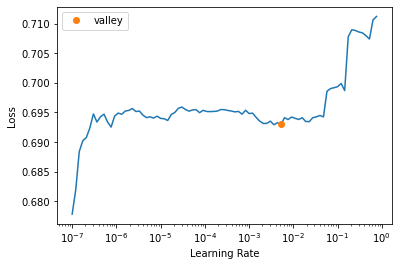

In [41]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.426767,0.401867,0.826000,01:52
1,0.282645,0.295986,0.874500,02:15
2,0.226144,0.283338,0.878000,02:46
3,0.145605,0.325866,0.875500,02:43
4,0.125661,0.348530,0.875500,02:38


Nice, but this model may have started overfitting near the end of training as it doesn't have any dropout, weight-decay, or other forms of regularization!

# 6. Using a Language Model via AWD-LSTM [fastai]

Using a pretrained language model for downstream tasks is a popular and efficient technique also! Fine-tuning the language model first is even better, as shown in [chapter 10 from fastbook](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb)

Here's a quick example of training a model with this dataset using fastai!

First we'll need to create our vocab as we did before!

In [43]:
fastai_vocab = make_vocab(token_counter)

To continue using the same subset dataframes, we'll combine both the `train_df` and `valid_df` into `combined_df`, then let fastai split at index 40k by using the `splitter` argument in the [DataBlocks API](https://docs.fast.ai/tutorial.datablock.html)!

In [44]:
# Creating a single DataFrame and to split within the DataBlocks API!
combined_df = pd.concat([train_df, valid_df])
combined_df.head()

,label,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
1,2,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
2,2,Amazing!,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if you've played the game) and the hope in ""A Distant Promise"" and ""Girl who Stole the Star"" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like ""Chrono Cross ~ Time's Scar~"", ""Time of the Dreamwatch"", and ""Chronomantique"" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xenogears s..."
3,2,Excellent Soundtrack,"I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Uns..."
4,2,"Remember, Pull Your Jaw Off The Floor After Hearing it","If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper."


In [45]:
len(combined_df)

42000

In [ ]:
amazon_polarity = DataBlock(blocks=(TextBlock.from_df('text', seq_len=128, vocab=fastai_vocab),
                                    CategoryBlock),
                            get_x=ColReader('text'),
                            get_y=ColReader('label'),
                            splitter=IndexSplitter(range(40000, 42000)))

# Passing a custom DataFrame in and splitting by the index!
dls = amazon_polarity.dataloaders(combined_df, bs=32)

In [48]:
# Checking for the correct amount of samples
len(dls.train_ds), len(dls.valid_ds)

(40000, 2000)

> Note: Looks good! We still have our 40k training samples and 2k validation samples :)

In [49]:
# Number of batches
len(dls.train), len(dls.valid)

(1250, 63)

In [50]:
dls.train.show_batch()

,text,category
0,xxbos xxup buyer xxup beware ! ! ! yes xxup the xxup diapers xxup are xxup good xxup but i xxup received xxup the xxup diapers xxup with xxup stains xxup they xxup look xxup like xxup dna xxup stains . xxup so i xxup call xxup the xxup company xxup and xxup they xxup instruct xxup me xxup to xxup xxunk xxup them xxup away xxup all 200 xxup diapers xxup wow . xxup so i xxup wait xxup in xxup the xxup mail xxup for xxup some xxup coupons xxup they xxup are xxup supposed xxup to xxup send xxup me xxup and xxup turns xxup out i xxup have xxup to xxup spend xxup more xxup money xxup in xxup order xxup to xxup get xxup the xxup diapers i xxup had xxup already xxup paid xxup for . xxup so i xxup call xxup company xxup,1
1,"xxbos xxup this xxup is xxup one xxup of xxup the xxup stupidest , xxup silly , xxup totally xxup xxunk xxup movies i xxup have xxup ever xxup seen . i xxup have xxup always xxup loved xxunk disasters xxup in xxup nature xxup movies xxunk . i xxup was xxup not xxup disapointed . xxup this xxup was xxup truly a xxup horrific xxup catastrophe . xxup the xxup best xxup part xxup of xxup the xxup movie xxup was xxunk xxunk was xxunk xxunk xxup was xxunk xxunk i xxup am xxup getting xxup there xxunk xxunk xxunk xxunk xxunk xxup the xxup story xxup had xxup no xxup meaning . xxup xxunk xxup xxunk xxup should xxup sell xxup xxunk xxup tickets xxup the xxup next xxup time xxup she xxup needs xxup money . xxup her xxup talents xxup were xxup totally xxup wasted .",1
2,"xxbos xxup if xxup you xxup take a xxup look xxup at xxup the 1 xxup star xxup review , i xxup am xxup the xxup one xxup that xxup left a xxup comment xxup in xxup favor , xxup but xxup wondering xxup why xxup they xxup left xxup only xxup one xxup star . xxup it xxup had xxup to xxup be a xxup mistake xxup because xxup she xxup gave xxup it a xxunk haunting xxunk xxup review , xxup if xxup not xxup too xxup short . xxup the xxup tune xxunk ' estate ' xxup is xxup with xxup out a xxup doubt a xxup five xxup star xxup tune . xxup in xxup fact , xxup one xxup of xxup the xxup most xxup beautiful xxup jazz xxup vocal xxup numbers i xxup can xxup remember xxup hearing . xxup however , xxup the",2
3,"xxbos xxmaj some may ask why , but i say bring on a collection like this . xxmaj why not ? xxmaj this is xxunk music . xxmaj is it techno or electronica , who cares , just dance and enjoy . xxmaj my biggest complaints are , why six tracks from xxunk homework xxunk , and only three from xxunk discovery xxunk ? xxmaj also , some of these songs like xxunk rollin ' & xxmaj xxunk ' xxunk and xxunk robot xxmaj rock xxunk are xxup so repetitive ( i know that xxunk the point ) , they get old by the three minute mark . xxmaj yet , other tracks like xxunk around xxmaj the xxmaj world xxunk and xxunk one xxmaj more xxmaj time xxunk are perfection , hence the classics they are . xxmaj one other disappointment xxunk xxunk the hell is xxunk digital xxmaj",2
4,"xxbos i absolutely loved this xxup cd and i think everyone in america should own a copy ( or maybe xxunk and my friends have been behind clay since the beginning ( well almost the beginning ) and were so excited when he got back on in the wild card show . i was so excited when this xxup cd came out . i love every song on this xxup cd and listen to it 24 / 7 ( more like 25 / xxunk ! xxmaj this is by far the best xxup cd i xxunk bought in years . xxmaj it was worth every penny . i ca nt wait for clays next xxup cd ! xxmaj people of all ages can enjoy clay xxunk music . xxmaj some of my favorites are xxmaj invisible , i will carry you , the way , when you say you love",2
5,"xxbos xxmaj this is one of the worst books in the world xxrep 3 - in my humble opinion ! xxup ok , xxmaj i xxunk in the minority . xxmaj most of the reviewers xxup loved the book . i think this book is a waste of beautiful words ! xxmaj yes , xxmaj conrad had a beautiful xxmaj english vocabulary . xxmaj but , the xxunk story xxunk is xxunk xx

> Tip: Take a close look at the samples above! We can see that we're not using a simple tokenizer that just separates on spaces anymore! This tokenizer has lots of additional special tokens and special rules to help with better feature/token engeineering! (e.g. `xxbos` -> beginning of a text, and `xxmaj` -> next word capitalized) More can be found here in [chapter 10 from fastbook](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb)

In [51]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy])

> Note: We'll be using the [AWD-LSTM](https://docs.fast.ai/text.models.awdlstm.html#AWD_LSTM) language model as our pretrained model to finetune!

SuggestedLRs(valley=tensor(0.0036))

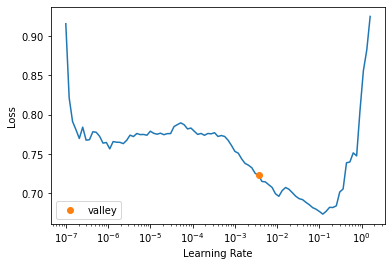

In [52]:
learn.lr_find()

In [53]:
learn.fine_tune(5, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.510850,0.458526,0.777000,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.391805,0.325548,0.858000,01:53
1,0.323382,0.286508,0.883500,01:53
2,0.265536,0.264187,0.892000,01:54
3,0.230185,0.256429,0.898500,01:54
4,0.202922,0.268608,0.897500,01:54


> Important: Compare the results of this model with the previous one we built with pure PyTorch. We can see regularization come into effect!

# 7. Using a Language Model via DistilBERT [HuggingFace & PyTorch & fastai]

We can load up a tokenizer and transformer from [HuggingFace's Transformers API](https://huggingface.co/transformers/) and train them using fastai! We'll be using [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) as it's smaller and faster than the original [BERT](https://huggingface.co/transformers/model_doc/bert.html).

> "[DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than `bert-base-uncased`, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark."

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

hf_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
hf_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [34]:
sample_text = train_df['text'][0]
sample_text

'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [35]:
tokenizer_outputs = hf_tokenizer(sample_text, return_tensors="pt")
tokenizer_outputs

{'input_ids': tensor([[  101,  2023,  2614,  2650,  2001,  3376,   999,  2009, 23262,  1996,
         12411,  7301,  1999,  2115,  2568,  2061,  2092,  1045,  2052, 28667,
          8462,  4859,  2009,  2130,  2000,  2111,  2040,  5223,  6819,  2094,
          1012,  2208,  2189,   999,  1045,  2031,  2209,  1996,  2208, 10381,
          4948,  2080,  2892,  2021,  2041,  1997,  2035,  1997,  1996,  2399,
          1045,  2031,  2412,  2209,  2009,  2038,  1996,  2190,  2189,   999,
          2009, 10457,  2185,  2013, 13587,  9019,  2075,  1998,  3138,  1037,
          4840,  2121,  3357,  2007, 24665,  3686,  7334,  1998,  3969,  3993,
         19505,  1012,  2009,  2052, 17894,  3087,  2040, 14977,  2000,  4952,
           999,  1034,  1035,  1034,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [36]:
tokenizer_outputs['input_ids'].shape, tokenizer_outputs['attention_mask'].shape

(torch.Size([1, 95]), torch.Size([1, 95]))

> Note: We can see that bert's tokenizer returns 2 items, `input_ids` (numericalization of tokens) and `attention_mask` (manually lets you control attention on specific tokens). DistilBERT will take both of these as input!

Let's go ahead and put this into another dataset class:

In [37]:
#collapse
class HF_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, hf_tokenizer):
        self.df = df
        self.hf_tokenizer = hf_tokenizer
        
        # label 1 is negative sentiment and label 2 is positive sentiment
        self.label_map = {1:0, 2:1}
        
    def __len__(self):
        return len(self.df)

    def decode(self, token_ids):
        return ' '.join([hf_tokenizer.decode(x) for x in tokenizer_outputs['input_ids']])
    
    def decode_to_original(self, token_ids):
        return self.hf_tokenizer.decode(token_ids.squeeze())

    def __getitem__(self, index):
        label, title, text = self.df.iloc[index]
        label = self.label_map[label]
        label = torch.tensor(label)

        tokenizer_output = self.hf_tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=512)
        
        tokenizer_output['input_ids'].squeeze_()
        tokenizer_output['attention_mask'].squeeze_()
        
        return tokenizer_output, label

In [38]:
train_dataset = HF_Dataset(train_df, hf_tokenizer)
valid_dataset = HF_Dataset(valid_df, hf_tokenizer)
len(train_dataset), len(valid_dataset)

(40000, 2000)

In [39]:
tokenizer_outputs, label = train_dataset[0]
tokenizer_outputs.keys(), label

(dict_keys(['input_ids', 'attention_mask']), tensor(1))

In [40]:
# Only printing first 500 characters due to the excess [PAD] tokens!
train_dataset.decode(tokenizer_outputs['input_ids'])[:500]

'[CLS] this sound track was beautiful ! it paints the sen ##ery in your mind so well i would rec ##ome ##nd it even to people who hate vi ##d . game music ! i have played the game ch ##ron ##o cross but out of all of the games i have ever played it has the best music ! it backs away from crude keyboard ##ing and takes a fresh ##er step with gr ##ate guitars and soul ##ful orchestras . it would impress anyone who cares to listen ! ^ _ ^ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ['

> Tip: Notice how DistilBERT also has a more efficient tokenizer compared to the standard tokenizer we used at the start. We can see it's using subword tokenization (e.g. `keyboarding` -> `keyboard` `##ing`, as well as `fresher` -> `fresh` `##er`)

Here's the original input (tokens decoded, but without the subword tokenization showing):

In [41]:
# Only printing first 500 characters due to the excess [PAD] tokens!
train_dataset.decode_to_original(tokenizer_outputs['input_ids'])[:500]

'[CLS] this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^ _ ^ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ['

In [42]:
train_dl = DataLoader(train_dataset, bs=16, shuffle=True)
valid_dl = DataLoader(valid_dataset, bs=16)
dls = DataLoaders(train_dl, valid_dl)

Let's make sure that items within the `tokenizer_outputs` dictionary can get batched together properly:

In [43]:
# Making sure things are getting batched correctly!
batched_data, batched_labels = train_dl.one_batch()
batched_data.keys(), batched_data['input_ids'].shape, batched_labels.shape

(dict_keys(['input_ids', 'attention_mask']),
 torch.Size([16, 512]),
 torch.Size([16]))

To allow this model to be trained by fastai, we need to ensure that the model simply takes a single input, and returns the logits. We can create a small class to handle the intermediate stuff (like the decoupling of tokenizer_outputs via `**tokenizer_outputs`, and extracting the logits from the model output via `.logits`. Here's an example of a forward pass using HF's tokenizer and model:

In [44]:
hf_model(**batched_data)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0196, -0.0800],
        [-0.1307, -0.0872],
        [-0.0604, -0.0986],
        [-0.1189, -0.0459],
        [-0.0588, -0.0984],
        [-0.0342, -0.0900],
        [-0.1314, -0.1056],
        [ 0.0286, -0.0227],
        [-0.0680, -0.0357],
        [-0.0157, -0.0817],
        [-0.0831, -0.0794],
        [-0.0725, -0.0759],
        [-0.0438, -0.1197],
        [-0.0845, -0.1267],
        [-0.0698, -0.0478],
        [-0.1017, -0.0566]], grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

In [45]:
#collapse
class HF_Model(nn.Module):
  
    def __init__(self, hf_model):
        super().__init__()
        
        self.hf_model = hf_model
        
    def forward(self, tokenizer_outputs):
        
        model_output = self.hf_model(**tokenizer_outputs)
        
        return model_output.logits

In [46]:
model = HF_Model(hf_model)

With the same data, here's an example of a forward pass with our small wrapper over the `hf_model`

In [47]:
logits = model(batched_data)
logits

tensor([[-0.0196, -0.0800],
        [-0.1307, -0.0872],
        [-0.0604, -0.0986],
        [-0.1189, -0.0459],
        [-0.0588, -0.0984],
        [-0.0342, -0.0900],
        [-0.1314, -0.1056],
        [ 0.0286, -0.0227],
        [-0.0680, -0.0357],
        [-0.0157, -0.0817],
        [-0.0831, -0.0794],
        [-0.0725, -0.0759],
        [-0.0438, -0.1197],
        [-0.0845, -0.1267],
        [-0.0698, -0.0478],
        [-0.1017, -0.0566]], grad_fn=<AddmmBackward>)

> Note: We no longer need double asteriks for decoupling the input data dictionary, and we don't need to extract the logits from the output via `.logits` This allows for easy compatability with `fastai`'s `Learner` class

We have everything we need to finetune this model now!

In [48]:
# Manually popping the model onto the gpu since the data is in a dictionary format
# (doesn't automatically place model + data on gpu otherwise)
learn = Learner(dls, model.cuda(), loss_func=nn.CrossEntropyLoss(), metrics=[accuracy])

SuggestedLRs(valley=tensor(3.6308e-05))

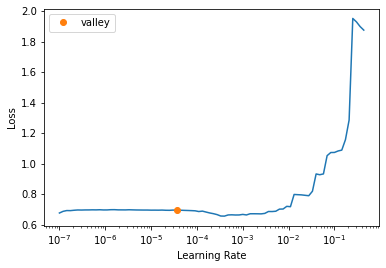

In [49]:
learn.lr_find()

In [50]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.240267,0.249942,0.897500,15:59
1,0.142634,0.211986,0.921000,15:56
2,0.068012,0.243243,0.926000,15:56


# 8. Conclusion

- We can take models written in pure PyTorch, or take existing models from elsewhere (e.g. HuggingFace), and train them with ease within fastai.
- NLP has lots of variation in terms of tokenization methods. In my personal opinion*, libaries like fastai & HuggingFace make the NLP data processing pipeline much easier/faster to get up and running!
- Each method has it's pros and cons:
  - DistilBERT may have performed better, but this model has a much much larger number of parameters and possibly a much larger vocabulary!
  - The runtime of DistilBERT was also much longer. ~16 minutes epochs (for a distilled transformer) vs ~2 min epochs (for a recurrent model)
  - In other tasks, it may be better to use a transformer, but for many common NLP tasks, sometimes a simpler/smaller model is good enough!
  - Even though transformers feed-forward it's input sequences in parallel (through positional encoding + self attention), they can be slower than simple recurrent networks due to their large model sizes.

> Note: All the results in this blog post/notebook may differ between runs, and that a "perfect" hyperparameter search was not performed for any of these models. This tutorial was mainly done for showing examples of NLP pipelines using different libaries!

Thanks for reading!!! 🙂